# Early testing of crop mask in Africa

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import os
import datacube
import dask
from pprint import pprint
import pandas as pd
import pydotplus
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import model_selection
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from datacube_stats.statistics import GeoMedian
from sklearn.metrics import accuracy_score
from datacube.helpers import write_geotiff
from joblib import dump
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../Scripts')
from deafrica_classificationtools import predict_xr, get_training_data_for_shp 
from deafrica_plotting import map_shapefile, rgb
from deafrica_datahandling import mostcommon_crs, load_ard
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster

%load_ext autoreload
%autoreload 2

### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the `dask dashboard`, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.


In [2]:
# !pip install msgpack==0.6.2
# create_local_dask_cluster(aws_unsigned=False)

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [3]:
dc = datacube.Datacube(app='crop mask')

### Analysis parameters
* `lat`, `long` & `buffer`: The centre location and buffer for your area of interest, this will define the box from which we extract satellite data to classify when we make the prediction.
* `path`: The path to the input shapefile. A default shapefile is provided.
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `product`: The name of the product to extract. In this example we use a geomedian composite from 2018, `'ga_ls8c_gm_2_annual'`
* `time`: The time range you wish to extract data for, typically the same date the labels were created.
* `reduce_func`: This will determine the statistic to reduce the time dimension of the loaded datasets (if loading multiple time steps). Options include `'mean'`, `'median'`, or `'geomedian'`. 
* `band_indices`: a list of band indices to calculate for the training data see [here](../Frequently_used_code/Calculating_band_indices.ipynb) for possible options.
* `collections`: In order to calculate band indices, the function needs to know which product we are using. Options include `'s2'` for Sentinel-2, `'c1'` for Landsat Collection 1, and `'c2'` for Landsat Collection 2.
* `drop`: If calculating band indices, we can optionally choose to drop the spectral bands loaded with the product, if `'drop=True'`, then only the band indices will be used for the training data.
* `zonal_stats`: This is an option to calculate the `'mean'` or `'median'` of the pixel values within each polygon feature, setting it to `None` will result in all pixels being extracted.
* `dask_chunks`: A dictionary of dimensions to 'chunk' our data by during loading e.g. `{'x':500, 'y':500, 'time':-1}`
* `resolution`: The spatial resolution, in metres, to resample the satellite data too e.g. if working with Landsat data, then this should be `(-30,30)` 
* `align`: How to align the pixel coordinates. e.g if working with Landsat data, then this should be `(15,15)`, which corresponds to the centre of a 30x30m pixel

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. 

In [4]:
#Nile Delta
lat = 30.881
long = 31.2
buffer = 0.75

path = 'data/GLCNMO_2008_crop_africa.shp' 
field = 'class'
results = "results/"
tree_graphs = 'results/tree_graphs/'
products = ['ga_ls8c_gm_2_annual']
time = ('2018')
reduce_func = None #'std'
band_indices = ['NDVI', 'EVI', 'NDWI'] 
collection =  'c2' 
drop = False
zonal_stats = None #'median' 
dask_chunks = {'x':1000, 'y':1000, 'time':-1}
resolution =  (-30, 30)
align = (15,15)


## Extract training data using a shapefile


In [5]:
#open shapefile and ensure its in WGS84 coordinates
input_data = gpd.read_file(path).to_crs('epsg:4326')

#check the shapefile by plotting it
map_shapefile(input_data, attribute=field)

Label(value='')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

In [6]:
#generate a datacube query object
query = {
    'time': time,
    'measurements': ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'],
    'dask_chunks': dask_chunks,
    'resolution': resolution,
    'align' : align,
    'group_by' :'solar_day',
}


In [7]:
# Empty list which we will populate with data
out = []

# Call the extraction function
column_names = get_training_data_for_shp(polygons=input_data, 
                                         out=out,
                                         products=products,
                                         dc_query=query,
                                         field=field,
                                         calc_indices=band_indices,
                                         drop=drop,
                                         reduce_func=reduce_func,
                                         zonal_stats=zonal_stats,
                                         collection=collection)


Calculating indices: ['NDVI', 'EVI', 'NDWI']


In [8]:
# Stack the extracted training data for each feature into a single array
model_input = np.vstack(out)
print(f'\nOutput training data has shape {model_input.shape}')


Output training data has shape (595836, 10)


## Preprocessing

`scitkit-learn` models cannot accept training data with `NaNs` ("not a number"). 
This preprocessing step removes any potential rows in the training array with `NaNs`.

In [9]:
# Remove any potential nans
model_input = model_input[~np.isnan(model_input).any(axis=1)]
print("Cleaned input shape:", model_input.shape)

Cleaned input shape: (595836, 10)


Our training data has multiple classes in it. However, we are only trying to predict one class (i.e. class 'urban') with this model. 
We therefore remove other classes from our training data by setting the label value for all other classes to 0.

In the cell below, set the class number that corresponds with the 'urban' training class in the shapefile

In [10]:
crop_class_int = 1

In [11]:
# Modify the input training data for single class labels
model_input[:,0] = np.where(model_input[:,0] == crop_class_int, 1, 0)

So that we can access the accuracy of our classification, we split our data into training and testing data. 
80% is used for training with 20% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [12]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, 
                                                           stratify=model_input[:, 0],
                                                           train_size=0.80, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (476668, 10)
Test shape: (119168, 10)


## Model preparation

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [13]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [column_names.index(var_name) for var_name in model_variables]

A **Random Forest Model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Parameter tuning can be conducted in the model initialisation below by adding or changing variables in the [classifier_params](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

In [14]:
# Dict of RF classifier parameters
classifier_params = {
    'n_jobs': 2,
    'n_estimators': 100,
    'criterion' : "entropy",
    'verbose': False,
    'max_features': 'auto',
    'min_samples_split':10,
    'min_samples_leaf': 10,
    'max_depth' : 5,
    'oob_score': True,
}

# model = tree.DecisionTreeClassifier()
# model = RandomForestClassifier()
model = RandomForestClassifier(**classifier_params, class_weight="balanced")

## Train model

The model is fitted / trained using the prepared training data. 


In [15]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=True, random_state=None, verbose=False,
                       warm_start=False)

### Optionally save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in other scripts should we wish to use the same model to classify a different region

In [16]:
# dump(model, 'ml_model.joblib')

### Optionally load a pre-calculated model

In [17]:
# from joblib import load
# rf_model = 'ml_model.joblib'
# model = load(rf_model)

## Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 


In [18]:
# Load the data based on query around the user supplied
lat = 29.275 
long = 31.031
buffer = 0.35

q = {'x': (long-buffer, long+buffer),
     'y': (lat+buffer, lat-buffer)}
query.update(q)

#get output crs    
output_crs = mostcommon_crs(dc=dc, product=products, query=query)

# load geomedian data
data = dc.load(product=products, **query)
data = data.where(data!=0, np.nan)

# ds = load_ard(dc=dc,
#               products=products,
#               output_crs=output_crs,
#               **query)
if band_indices is not None:
    data = calculate_indices(data,
                         index=band_indices,
                         drop=drop,
                         collection=collection)
# data = data.std('time')

In [19]:
# Predict landcover using the trained model
predicted = predict_xr(model, data, progress=True)

[########################################] | 100% Completed | 20.5s


## Plotting

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - Use the `Evaluate Classifier` steps below to help you improve the model

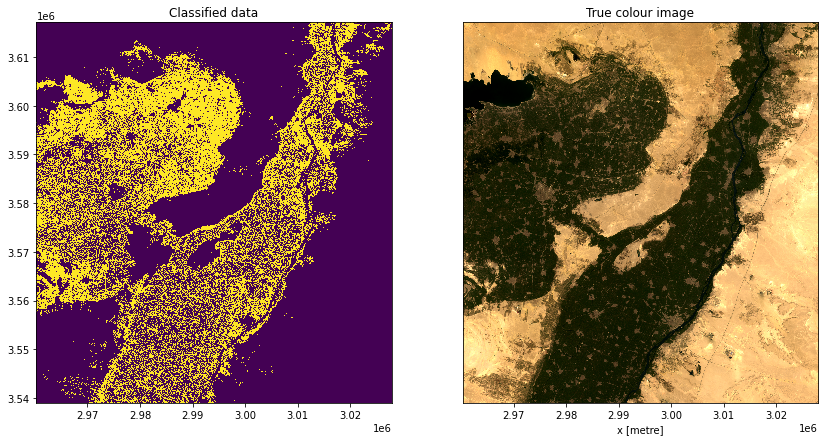

In [20]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot classified image
predicted.plot(ax=axes[0], 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
# data.NDVI.plot(ax=axes[1])
rgb(data, ax=axes[1], percentile_stretch=(0.05, 0.95))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');

---

## Evaluating Classifier

The following cells will help you examine the classifier and improve the results.  We can do this by:
* Determining our overall accuracy,
* Finding out which features (bands in the input data) are most useful for classifying, and which are not,
* Plotting the Decision Tree to help us understand which thresholds are used to seperate the classes,
* Testing different input parameters to help us optimise the model 

### Overall Accuracy

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.


In [21]:
predictions = model.predict(model_test[:, model_col_indices])
str(round(accuracy_score(predictions, model_test[:, 0], 2) *100)) + ' %'

'48.0 %'

### Determine Feature Importance

Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). Results will be presented in descending order with the most important features listed first.  Importance is reported as a relative fraction between 0 and 1.

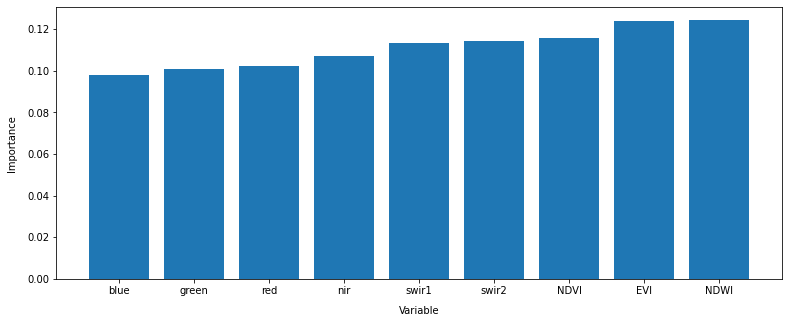

In [22]:
# This shows the feature importance of the input features for predicting the class labels provided
plt.figure(figsize=(13,5))
plt.bar(x=model_variables, height=np.sort(model.feature_importances_))
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

### Test parameter values of model

This will help us determine which paramater values are best to use for our model. The function [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) will exhaustively search through the parameters in `param_grid` and determine the combination that will result in the highest accuracy (based on the `out-of-bag` metric).


In [ ]:
param_grid = {
    'min_samples_split': [5,10,50],
    'min_samples_leaf': [5,10,50],
#     "max_features": ['sqrt', 'log2', 'auto'],
    "n_estimators" : [100,200,500],
#     'criterion': ['entropy', 'gini'],
    'max_depth': [1,2,5]
}

grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(model_train[:, model_col_indices], model_train[:, 0])

print("The most accurate combination of tested parameters is: ")
pprint(grid_search.best_params_)

### Export tree diagrams

Export .png plots of each decision tree in the random forest ensemble. Useful for inspecting the splits used by the classifier to classify the data.

In [23]:
for n, tree_in_forest in enumerate(model.estimators_):    

    # Create graph and save to dot file
    export_graphviz(tree_in_forest,
                    out_file = tree_graphs + "tree.dot",
                    feature_names = model_variables,
                    class_names = ['crop', 'non-crop'],
                    filled = True,
                    rounded = True)

    # Plot as figure
    os.system('dot -Tpng ' + tree_graphs + 'tree.dot -o ' + tree_graphs + 'tree' + str(n + 1) + '.png')    

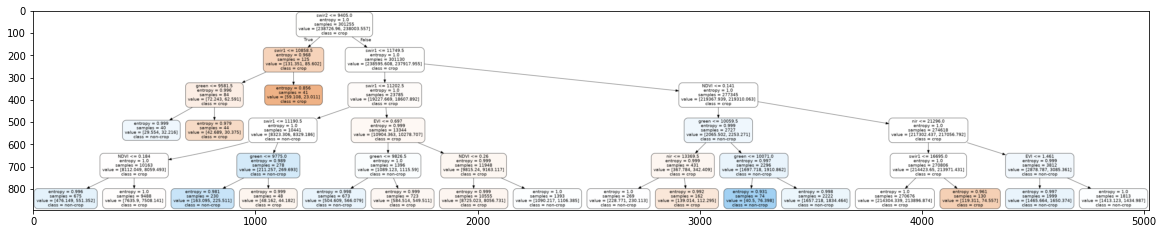

In [24]:
# Plot any tree
tree_number = 'tree1'

img = plt.imread(tree_graphs + tree_number + '.png')
plt.figure(figsize = (20, 20))
plt.imshow(img, interpolation = "bilinear")

## Exporting classification
We can now export the predicted landcover out to a GeoTIFF `.tif` file. 
This file can be loaded into GIS software (e.g. QGIS, ArcMap) to be inspected more closely.

In [ ]:
# Write the predicted data out to a GeoTIFF
predicted_ds = predicted.to_dataset(name="predicted")
predicted_ds.attrs['crs'] = data.crs
write_geotiff('predicted.tif', predicted_ds.squeeze())